## Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import generate_masterdf as gm
from preproc_funcs import add_metrics, filter_data, elim_subs_blocks
from generate_plots import daywise_heatmap, daywise_trend, daywise_trend_dual_metric, plot_error_metric
from helpers import calculate_mean_and_se
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import sem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)

msize = 10
axes_fontsize = 14
title_fontsize = 18
%load_ext autoreload
%autoreload 2

Loading existing dataframe! If this is not desired, delete the current mater_df.csv
Loading existing dataframe! If this is not desired, delete the current mater_df.csv


## Summarizing data features

In [2]:
# Loading the data as a dataframe
df_calib_orig = gm.master_calib_df
df_nocalib_orig = gm.master_nocalib_df

# Add additonal error metrics
df_calib_orig = add_metrics(df_calib_orig)
df_nocalib_orig = add_metrics(df_nocalib_orig)

# Preprocess and filter both datasets
df_calib, df_calib_all5 = filter_data(df_calib_orig)
df_nocalib, df_nocalib_all5 = filter_data(df_nocalib_orig)

sub_list_all5 = np.unique(df_calib_all5['subjID'].values)
sub_list = np.unique(df_calib['subjID'].values)

Trials removed = 4686 = 14.25% 
Timing issues = 65 = 0.2% 
No saccades detected issues = 2926 = 8.9% 
Reaction time issues = 178 = 0.54% 
Large errors = 1517 = 4.61% 

Trials removed = 4009 = 12.19% 
Timing issues = 65 = 0.2% 
No saccades detected issues = 2248 = 6.84% 
Reaction time issues = 517 = 1.57% 
Large errors = 1179 = 3.59% 



In [ ]:
# Choose what you wanna see
print('Dataframe description')
df_calib.info()
df_calib.describe(include=object)
df_nocalib.info()
df_nocalib.describe(include=object)

## Visualization

In [ ]:
# Selecting features
df_to_visualize = df_calib
small_df = df_to_visualize.sample(frac=0.1, random_state=42)

cat_cols = df_calib.select_dtypes(include=['object']).columns
numer_cols = ['age', 'weight', 'TarX', 'TarY', 'isaccX', 'isaccY', 'fsaccX',
       'fsaccY', 'nsacc', 'isacc_rt', 'fsacc_rt', 'isacc_peakvel',
       'fsacc_peakvel', 'ierrX', 'ierrY', 'ferrX',
       'ferrY', 'ierr', 'ferr', 'igain', 'fgain', 'eccentricity', 'polang',
       'ipea', 'fpea', 'iang', 'fang', 'itheta', 'iradial', 'itangential',
       'ftheta', 'fradial', 'ftangential', 'ierr_threshold', 'ferr_threshold']

### Visualize numerical columns

In [ ]:
plt.figure(figsize=(25, 40))
for i, col in enumerate(numer_cols):
    plt.subplot(7, 5, i + 1)
    sns.histplot(x=col, data=small_df)
    plt.xticks(rotation=45)
plt.show()

In [ ]:
# Check for correlation in data
plt.figure(figsize=(20, 20))
corr_matrix = df_to_visualize[numer_cols].corr()
mask = (corr_matrix > 0.25) | (corr_matrix < -0.25)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask = ~mask,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.show()

### Visualize categorical columns

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols):
    plt.subplot(2, 4, i + 1)
    sns.countplot(x=col, data=df_calib)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
meta_data = df_calib.groupby('subjID').agg({
    'day': 'max',
    'gender': 'first',
    'race': 'first',  
    'handedness': 'first',  
    'hemistimulated': 'first',  
    'age': 'first',
    'weight': 'first',  
    'eegsize': 'first', 
}).reset_index()
print(meta_data.describe())

### Check #trials kept

In [ ]:
daywise_heatmap(df_nocalib, df_nocalib_all5, sub_list, 'trial_count')
daywise_heatmap(df_calib, df_calib_all5, sub_list, 'trial_count')

In [ ]:
daywise_trend(df_calib, df_calib_all5, df_nocalib, df_nocalib_all5, sub_list, 'ierr')

### Subject and block eliminations

In [3]:
subs_to_remove = [8, 11, 13, 16, 18]
df_calib_filt, df_calib_all5_filt, df_nocalib_filt, df_nocalib_all5_filt = elim_subs_blocks(df_calib, df_calib_all5, df_nocalib, df_nocalib_all5, subs_to_remove)
sub_list_filt = [ss for ss in sub_list if ss not in subs_to_remove]
sub_list_all5_filt = [ss for ss in sub_list_all5 if ss not in subs_to_remove]

Removed subjects: [8, 11, 13, 16, 18]
Removed blocks df1:
    subjID  day  rnum
0        5    1    10
1        5    3     4
2        5    3     8
3        7    2     2
4       12    2     8
5       12    2     9
6       12    2    10
7       12    3     6
8       12    3     8
9       12    3     9
10      12    3    10
11      15    5     1
12      17    2     4
13      17    2     6
14      17    2     7
15      17    2     8
16      17    3     5
17      22    1     1
18      22    1     7
19      22    4     4
20      22    4     5
21      25    1     8
22      25    1     9
23      25    3     5
24      26    3     5
25      26    3     7
26      26    3    10
27      27    1     1


In [ ]:
data_calib = []
for sub in sub_list_filt:
    tdf_calib = df_calib_filt[df_calib_filt['subjID'] == sub]

    subj_data = {
        ('NoTMS', 'pro', 'block'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 1)]['rnum'].nunique(),
        ('NoTMS', 'pro', 'trial'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 1)]['tnum'].count(),
        ('NoTMS', 'anti', 'block'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 0)]['rnum'].nunique(),
        ('NoTMS', 'anti', 'trial'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 0)]['tnum'].count(),
        ('MidTMS', 'pro', 'block'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 1)]['rnum'].nunique(),
        ('MidTMS', 'pro', 'trial'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 1)]['tnum'].count(),
        ('MidTMS', 'anti', 'block'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 0)]['rnum'].nunique(),
        ('MidTMS', 'anti', 'trial'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 0)]['tnum'].count(),
        ('EarlyTMS', 'pro', 'block'): tdf_calib[tdf_calib['day'] == 4]['rnum'].nunique(),
        ('EarlyTMS', 'pro', 'trial'): tdf_calib[tdf_calib['day'] == 4]['tnum'].count(),
        ('MidTMS dangit', 'pro', 'block'): tdf_calib[tdf_calib['day'] == 5]['rnum'].nunique(),
        ('MidTMS dangit', 'pro', 'trial'): tdf_calib[tdf_calib['day'] == 5]['tnum'].count(),
    }

    data_calib.append(subj_data)
count_summary_calib = pd.DataFrame(data_calib, index=sub_list_filt)
count_summary_calib.columns = pd.MultiIndex.from_tuples(count_summary_calib.columns)
count_summary_calib.index.name = 'subjID'

data_nocalib = []
for sub in sub_list_filt:
    tdf_nocalib = df_nocalib_filt[df_nocalib_filt['subjID'] == sub]
    subj_data = {
        ('NoTMS', 'pro', 'block'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 1)]['rnum'].nunique(),
        ('NoTMS', 'pro', 'trial'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 1)]['tnum'].count(),
        ('NoTMS', 'anti', 'block'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 0)]['rnum'].nunique(),
        ('NoTMS', 'anti', 'trial'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 0)]['tnum'].count(),
        ('MidTMS', 'pro', 'block'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 1)]['rnum'].nunique(),
        ('MidTMS', 'pro', 'trial'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 1)]['tnum'].count(),
        ('MidTMS', 'anti', 'block'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 0)]['rnum'].nunique(),
        ('MidTMS', 'anti', 'trial'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 0)]['tnum'].count(),
        ('EarlyTMS', 'pro', 'block'): tdf_nocalib[tdf_nocalib['day'] == 4]['rnum'].nunique(),
        ('EarlyTMS', 'pro', 'trial'): tdf_nocalib[tdf_nocalib['day'] == 4]['tnum'].count(),
        ('MidTMS dangit', 'pro', 'block'): tdf_nocalib[tdf_nocalib['day'] == 5]['rnum'].nunique(),
        ('MidTMS dangit', 'pro', 'trial'): tdf_nocalib[tdf_nocalib['day'] == 5]['tnum'].count(),
    }
    data_nocalib.append(subj_data)
count_summary_nocalib = pd.DataFrame(data_nocalib, index=sub_list_filt)
count_summary_nocalib.columns = pd.MultiIndex.from_tuples(count_summary_nocalib.columns)
count_summary_nocalib.index.name = 'subjID'

def reshape_for_heatmap(df, count_type):
    df_reshaped = df.xs(count_type, level=2, axis=1)
    df_reshaped = df_reshaped.stack([0, 1]).reset_index()
    df_reshaped.columns = ['subjID', 'Condition', 'Type', count_type]
    return df_reshaped

data_calib_block = reshape_for_heatmap(count_summary_calib, 'block')
data_calib_trial = reshape_for_heatmap(count_summary_calib, 'trial')
data_nocalib_block = reshape_for_heatmap(count_summary_nocalib, 'block')
data_nocalib_trial = reshape_for_heatmap(count_summary_nocalib, 'trial')

data_calib = pd.merge(data_calib_block, data_calib_trial, on=['subjID', 'Condition', 'Type'])
data_nocalib = pd.merge(data_nocalib_block, data_nocalib_trial, on=['subjID', 'Condition', 'Type'])

desired_order = [
    ('NoTMS', 'pro'),
    ('NoTMS', 'anti'),
    ('MidTMS', 'pro'),
    ('MidTMS', 'anti'),
    ('EarlyTMS', 'pro'),
    ('MidTMS dangit', 'pro'),
]

p_calib_block = data_calib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='block')
p_calib_block = p_calib_block.reindex(desired_order, axis=1)
p_calib_trial = data_calib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='trial')
p_calib_trial = p_calib_trial.reindex(desired_order, axis=1)
p_nocalib_block = data_nocalib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='block')
p_nocalib_block = p_nocalib_block.reindex(desired_order, axis=1)
p_nocalib_trial = data_nocalib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='trial')
p_nocalib_trial = p_nocalib_trial.reindex(desired_order, axis=1)

fig, axs = plt.subplots(2, 2, figsize=(15, 25))

sns.heatmap(p_calib_block, cmap='Blues', annot=True, fmt='g', ax=axs[1, 0])
axs[1, 0].set_title('Calib - Block Count')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Subject ID')

sns.heatmap(p_calib_trial, cmap='Greens', annot=True, fmt='g', ax=axs[1, 1])
axs[1, 1].set_title('Calib - Trial Count')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('Subject ID')

sns.heatmap(p_nocalib_block, cmap='Blues', annot=True, fmt='g', ax=axs[0, 0])
axs[0, 0].set_title('Nocalib - Block Count')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Subject ID')

sns.heatmap(p_nocalib_trial, cmap='Greens', annot=True, fmt='g', ax=axs[0, 1])
axs[0, 1].set_title('Nocalib - Trial Count')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Subject ID')

plt.show()

In [ ]:
data_calib = []
for sub in sub_list_filt:
    tdf_calib = df_calib_filt[df_calib_filt['subjID'] == sub]

    subj_data = {
        ('NoTMS', 'pro', 'ierr'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 1)]['ierr'].mean(),
        ('NoTMS', 'pro', 'isacc_rt'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 1)]['isacc_rt'].mean(),
        ('NoTMS', 'anti', 'ierr'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 0)]['ierr'].mean(),
        ('NoTMS', 'anti', 'isacc_rt'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 0) & (tdf_calib['ispro'] == 0)]['isacc_rt'].mean(),
        ('MidTMS', 'pro', 'ierr'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 1)]['ierr'].mean(),
        ('MidTMS', 'pro', 'isacc_rt'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 1)]['isacc_rt'].mean(),
        ('MidTMS', 'anti', 'ierr'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 0)]['ierr'].mean(),
        ('MidTMS', 'anti', 'isacc_rt'): tdf_calib[(tdf_calib['day'] < 4) & (tdf_calib['istms'] == 1) & (tdf_calib['ispro'] == 0)]['isacc_rt'].mean(),
        ('EarlyTMS', 'pro', 'ierr'): tdf_calib[tdf_calib['day'] == 4]['ierr'].mean(),
        ('EarlyTMS', 'pro', 'isacc_rt'): tdf_calib[tdf_calib['day'] == 4]['isacc_rt'].mean(),
        ('MidTMS dangit', 'pro', 'ierr'): tdf_calib[tdf_calib['day'] == 5]['ierr'].mean(),
        ('MidTMS dangit', 'pro', 'isacc_rt'): tdf_calib[tdf_calib['day'] == 5]['isacc_rt'].mean(),
    }

    data_calib.append(subj_data)
count_summary_calib = pd.DataFrame(data_calib, index=sub_list_filt)
count_summary_calib.columns = pd.MultiIndex.from_tuples(count_summary_calib.columns)
count_summary_calib.index.name = 'subjID'


data_nocalib = []
for sub in sub_list_filt:
    tdf_nocalib = df_nocalib_filt[df_nocalib_filt['subjID'] == sub]
    subj_data = {
        ('NoTMS', 'pro', 'ierr'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 1)]['ierr'].mean(),
        ('NoTMS', 'pro', 'isacc_rt'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 1)]['isacc_rt'].mean(),
        ('NoTMS', 'anti', 'ierr'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 0)]['ierr'].mean(),
        ('NoTMS', 'anti', 'isacc_rt'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 0) & (tdf_nocalib['ispro'] == 0)]['isacc_rt'].mean(),
        ('MidTMS', 'pro', 'ierr'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 1)]['ierr'].mean(),
        ('MidTMS', 'pro', 'isacc_rt'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 1)]['isacc_rt'].mean(),
        ('MidTMS', 'anti', 'ierr'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 0)]['ierr'].mean(),
        ('MidTMS', 'anti', 'isacc_rt'): tdf_nocalib[(tdf_nocalib['day'] < 4) & (tdf_nocalib['istms'] == 1) & (tdf_nocalib['ispro'] == 0)]['isacc_rt'].mean(),
        ('EarlyTMS', 'pro', 'ierr'): tdf_nocalib[tdf_nocalib['day'] == 4]['ierr'].mean(),
        ('EarlyTMS', 'pro', 'isacc_rt'): tdf_nocalib[tdf_nocalib['day'] == 4]['isacc_rt'].mean(),
        ('MidTMS dangit', 'pro', 'ierr'): tdf_nocalib[tdf_nocalib['day'] == 5]['ierr'].mean(),
        ('MidTMS dangit', 'pro', 'isacc_rt'): tdf_nocalib[tdf_nocalib['day'] == 5]['isacc_rt'].mean(),
    }
    data_nocalib.append(subj_data)
count_summary_nocalib = pd.DataFrame(data_nocalib, index=sub_list_filt)
count_summary_nocalib.columns = pd.MultiIndex.from_tuples(count_summary_nocalib.columns)
count_summary_nocalib.index.name = 'subjID'

def reshape_for_heatmap(df, count_type):
    df_reshaped = df.xs(count_type, level=2, axis=1)
    df_reshaped = df_reshaped.stack([0, 1]).reset_index()
    df_reshaped.columns = ['subjID', 'Condition', 'Type', count_type]
    return df_reshaped

data_calib_block = reshape_for_heatmap(count_summary_calib, 'ierr')
data_calib_trial = reshape_for_heatmap(count_summary_calib, 'isacc_rt')
data_nocalib_block = reshape_for_heatmap(count_summary_nocalib, 'ierr')
data_nocalib_trial = reshape_for_heatmap(count_summary_nocalib, 'isacc_rt')

data_calib = pd.merge(data_calib_block, data_calib_trial, on=['subjID', 'Condition', 'Type'])
data_nocalib = pd.merge(data_nocalib_block, data_nocalib_trial, on=['subjID', 'Condition', 'Type'])

desired_order = [
    ('NoTMS', 'pro'),
    ('NoTMS', 'anti'),
    ('MidTMS', 'pro'),
    ('MidTMS', 'anti'),
    ('EarlyTMS', 'pro'),
    ('MidTMS dangit', 'pro'),
]

p_calib_block = data_calib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='ierr')
p_calib_block = p_calib_block.reindex(desired_order, axis=1)
p_calib_trial = data_calib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='isacc_rt')
p_calib_trial = p_calib_trial.reindex(desired_order, axis=1)
p_nocalib_block = data_nocalib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='ierr')
p_nocalib_block = p_nocalib_block.reindex(desired_order, axis=1)
p_nocalib_trial = data_nocalib.pivot_table(index='subjID', columns=['Condition', 'Type'], values='isacc_rt')
p_nocalib_trial = p_nocalib_trial.reindex(desired_order, axis=1)

fig, axs = plt.subplots(2, 2, figsize=(15, 25))

sns.heatmap(p_calib_block, cmap='Blues', annot=True, fmt='.2f', ax=axs[1, 0])
axs[1, 0].set_title('Calib - Block Count')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Subject ID')

sns.heatmap(p_calib_trial, cmap='Greens', annot=True, fmt='.2f', ax=axs[1, 1])
axs[1, 1].set_title('Calib - Trial Count')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('Subject ID')

sns.heatmap(p_nocalib_block, cmap='Blues', annot=True, fmt='.2f', ax=axs[0, 0])
axs[0, 0].set_title('Nocalib - Block Count')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Subject ID')

sns.heatmap(p_nocalib_trial, cmap='Greens', annot=True, fmt='.2f', ax=axs[0, 1])
axs[0, 1].set_title('Nocalib - Trial Count')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Subject ID')

plt.show()

In [ ]:
daywise_trend(df_calib_filt, df_calib_all5_filt, df_nocalib_filt, df_nocalib_all5_filt, sub_list_filt, 'ierr')

In [ ]:
daywise_trend_dual_metric(df_calib_filt, df_calib_all5_filt, df_nocalib_filt, df_nocalib_all5_filt, sub_list_filt, ['ierr', 'isacc_rt'])

In [ ]:
err_sum, err_sum_all5, err_sum_all5_analysis = plot_error_metric(df_calib_filt, df_calib_all5_filt, sub_list_filt, sub_list_all5_filt, 'ierr')

In [ ]:
def compute_stats(summary_df, condition, aspect):
    if condition == 'time':
        summary_df = summary_df.groupby(['subjID', 'time']).agg({
            'Condition': 'first',
            'mean': 'mean',
            'se': 'mean'
        })
    
    friedman_data = [group[aspect].values for _, group in summary_df.groupby(condition)]
    friedman_stat, friedman_p = stats.friedmanchisquare(*friedman_data)
    print(f'Statistical analsysis for: {condition}: {aspect}')
    print(f'Friedman Test Statistic: {round(friedman_stat, 3)}, P-value: {round(friedman_p, 3)}')

    if friedman_p < 0.05:
        if condition == 'Condition':
            comparison_pairs = [
                ('mid inVF', 'mid outVF'),
                ('early inVF', 'early outVF'),
                ('mid dangit inVF', 'mid dangit outVF'),
            ]
        elif condition == 'time':
            comparison_pairs = [
                ('notms', 'mid'),
                ('notms', 'early'),
                ('notms', 'mid dangit')
            ]
        num_tests = len(comparison_pairs)+1 # +1 for Friedman test
        alpha_adjusted = 0.05 / num_tests  
        print(f'Corrected alpha value after Bonferroni correction for {num_tests} tests = {round(alpha_adjusted, 4)}')

        results = []

        for pair in comparison_pairs:
            condition1, condition2 = pair
            data1 = summary_df[summary_df[condition] == condition1][aspect]
            data2 = summary_df[summary_df[condition] == condition2][aspect]
            stat, pval = stats.wilcoxon(data1, data2)
            pval_adj = pval * num_tests
            reject = pval < alpha_adjusted
            results.append([condition1, condition2, stat, pval, pval_adj, reject])

        results_df = pd.DataFrame(results, columns=['Condition 1', 'Condition 2', 'WRS_stat', 'p-value', 'adj p-value', 'Reject Null'])
        print(results_df)
          
compute_stats(err_sum_all5, 'Condition', 'mean')
compute_stats(err_sum_all5, 'Condition', 'se')

In [ ]:
def compute_diff(x, y, axis):
    return np.mean(x, axis) - np.mean(y, axis)

def perform_permutation_test(df, time1, VF1, time2, VF2, title_text, ax):
    dat1 = df[(df['time'] == time1) & (df['VF'] == VF1)]['mean']
    dat2 = df[(df['time'] == time2) & (df['VF'] == VF2)]['mean']

    res = stats.permutation_test((dat1, dat2), compute_diff, vectorized=True, permutation_type='samples',
                                 n_resamples=1e6, alternative='two-sided', random_state=42)

    sns.histplot(res.null_distribution, element='step', fill=False, ax=ax)
    ax.axvline(x=res.statistic, color='k', linestyle='--')
    # ax.set_xlim([-0.35, 0.35])
    # ax.text(-0.25, 1000.2, f'stat={res.statistic:.3f}\np={res.pvalue:.3f}', fontsize=9, color='black')
    ax.set_title(title_text)
    return res.pvalue

df_analysis = err_sum_all5_analysis

pairs_to_test = [
    ('early', 1, 'early', 0, 'early in vs out'),
    ('mid', 1, 'mid', 0, 'mid in vs out'),
    ('mid dangit', 1, 'mid dangit', 0, 'mid dangit in vs out'),
    ('early', 1, 'notms', 1, 'notms vs early for inVF'),
    ('early', 0, 'notms', 0, 'notms vs early for outVF'),
    ('mid', 1, 'notms', 1, 'notms vs mid for inVF'),
    ('mid', 1, 'mid dangit', 1, 'mid vs mid dangit for inVF')
]

n_tests = len(pairs_to_test)
n_cols = 2 
n_rows = n_tests // n_cols + (n_tests % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]
for i, (time1, VF1, time2, VF2, title_text) in enumerate(pairs_to_test):
    perform_permutation_test(df_analysis, time1, VF1, time2, VF2, title_text, axes[i])
plt.show()

In [4]:
def get_summary(df_all5, metric):

    # conds_all5_analysis = {
    #     'No TMS inVF': df_all5[(df_all5['TMS_condition'] == 'No TMS') & (df_all5['instimVF'] == 1) & (df_all5['day'].isin([1, 2, 3]))],
    #     'No TMS outVF': df_all5[(df_all5['TMS_condition'] == 'No TMS') & (df_all5['instimVF'] == 0) & (df_all5['day'].isin([1, 2, 3]))],
    #     'mid inVF': df_all5[(df_all5['TMS_condition'] == 'TMS intoVF') & (df_all5['day'].isin([1, 2, 3]))],
    #     'mid outVF': df_all5[(df_all5['TMS_condition'] == 'TMS outVF') & (df_all5['day'].isin([1, 2, 3]))],
    #     'early inVF': df_all5[(df_all5['TMS_condition'] == 'TMS intoVF') & (df_all5['day'] == 4)],
    #     'early outVF': df_all5[(df_all5['TMS_condition'] == 'TMS outVF') & (df_all5['day'] == 4)],
    #     'mid dangit inVF': df_all5[(df_all5['TMS_condition'] == 'TMS intoVF') & (df_all5['day'] == 5)],
    #     'mid dangit outVF': df_all5[(df_all5['TMS_condition'] == 'TMS outVF') & (df_all5['day'] == 5)],
    # }

    conds_all5_analysis = {
        'No TMS inVF': df_all5[(df_all5['istms'] == 0) & (df_all5['instimVF'] == 1) & (df_all5['day'].isin([1, 2, 3]))],
        'No TMS outVF': df_all5[(df_all5['istms'] == 0) & (df_all5['instimVF'] == 0) & (df_all5['day'].isin([1, 2, 3]))],
        'mid inVF': df_all5[(df_all5['itms'] == 1) & (df_all5['instimVF'] == 1) & (df_all5['day'].isin([1, 2, 3]))],
        'mid outVF': df_all5[(df_all5['istms'] == 1) & (df_all5['instimVF'] == 0) & (df_all5['day'].isin([1, 2, 3]))],
        'early inVF': df_all5[(df_all5['istms'] == 1) & (df_all5['instimVF'] == 1) & (df_all5['day'] == 4)],
        'early outVF': df_all5[(df_all5['istms'] == 1) & (df_all5['instimVF'] == 0) & (df_all5['day'] == 4)],
        'mid dangit inVF': df_all5[(df_all5['istms'] == 1) & (df_all5['instimVF'] == 1) & (df_all5['day'] == 5)],
        'mid dangit outVF': df_all5[(df_all5['istms'] == 1) & (df_all5['instimVF'] == 0) & (df_all5['day'] == 5)],
    }
    
    results_all5_analysis = {cond: data.groupby('subjID').apply(calculate_mean_and_se, error_metric=metric) for cond, data in conds_all5_analysis.items()}
    combined_all5_analysis = pd.concat(results_all5_analysis, names=['Condition']).reset_index()
    combined_all5_analysis['time'] = combined_all5_analysis['Condition'].apply(lambda x: 'notms' if 'No TMS' in x else ('early' if 'early' in x else ('mid dangit' if 'mid dangit' in x else 'mid')))
    combined_all5_analysis['VF'] = combined_all5_analysis['Condition'].apply(lambda x: 1 if 'inVF' in x else 0)
    return combined_all5_analysis

def compute_stats_parametric(df, pairs_to_test):
    tvect = np.zeros((len(pairs_to_test),))
    for i, (time1, VF1, time2, VF2, _) in enumerate(pairs_to_test):
        data1 = df[(df['time'] == time1) & (df['VF'] == VF1)]['mean']
        data2 = df[(df['time'] == time2) & (df['VF'] == VF2)]['mean']
        tstat, _ = stats.ttest_rel(data1, data2, nan_policy = 'omit', alternative='two-sided')
        tvect[i] = tstat
    return tvect
    

start = time.time()
iter_count = 100000
pairs_to_test = [
    ('early', 1, 'early', 0, 'early in vs out'),
    ('mid', 1, 'mid', 0, 'mid in vs out'),
    ('mid dangit', 1, 'mid dangit', 0, 'mid dangit in vs out'),
    ('early', 1, 'notms', 1, 'notms vs early for inVF'),
    ('early', 0, 'notms', 0, 'notms vs early for outVF'),
    ('mid', 1, 'notms', 1, 'notms vs mid for inVF'),
    ('mid', 1, 'mid dangit', 1, 'mid vs mid dangit for inVF')
]
n_tests = len(pairs_to_test)
n_cols = 2 
n_rows = n_tests // n_cols + (n_tests % n_cols > 0)

tstat_compiled = np.zeros((iter_count, len(pairs_to_test)))

for ii in range(iter_count):
    df_temp = df_calib_all5_filt.copy()
    #cond_shuffle = np.random.permutation(df_temp['TMS_condition'])
    istms_shuffle = np.random.permutation(df_temp['istms'])
    stimVF_shuffle = np.random.permutation(df_temp['instimVF'])
    day_shuffle = np.random.permutation(df_temp['day'])
    #df_temp['TMS_condition'] = cond_shuffle
    df_temp['istms'] = istms_shuffle
    df_temp['instimVF'] = stimVF_shuffle
    df_temp['day'] = day_shuffle
    df_analysis = get_summary(df_temp, 'ierr')
    tvect_this = compute_stats_parametric(df_analysis, pairs_to_test)
    tstat_compiled[ii, :] = tvect_this

df_analysis_real = get_summary(df_calib_all5_filt, 'ierr')
tstat_real = compute_stats_parametric(df_analysis_real, pairs_to_test)
pval_2side = []
pval_1side = []
for ii in range(n_tests):
    if tstat_real[ii] >= 0:
        samps_bothside = sum(tstat_compiled[:, ii] >= tstat_real[ii]) + sum(tstat_compiled[:, ii] < -tstat_real[ii])
    else:
        samps_bothside = sum(tstat_compiled[:, ii] >= -tstat_real[ii]) + sum(tstat_compiled[:, ii] < tstat_real[ii])
    samps_oneside = sum(tstat_compiled[:, ii] >= tstat_real[ii])
    pval_2side.append(samps_bothside/iter_count)
    pval_1side.append(samps_oneside/iter_count)
print(f"Total time taken for running {iter_count} permutations: {round(time.time()-start, 3)} s")

Total time taken for running 100000 permutations: 2755.777 s


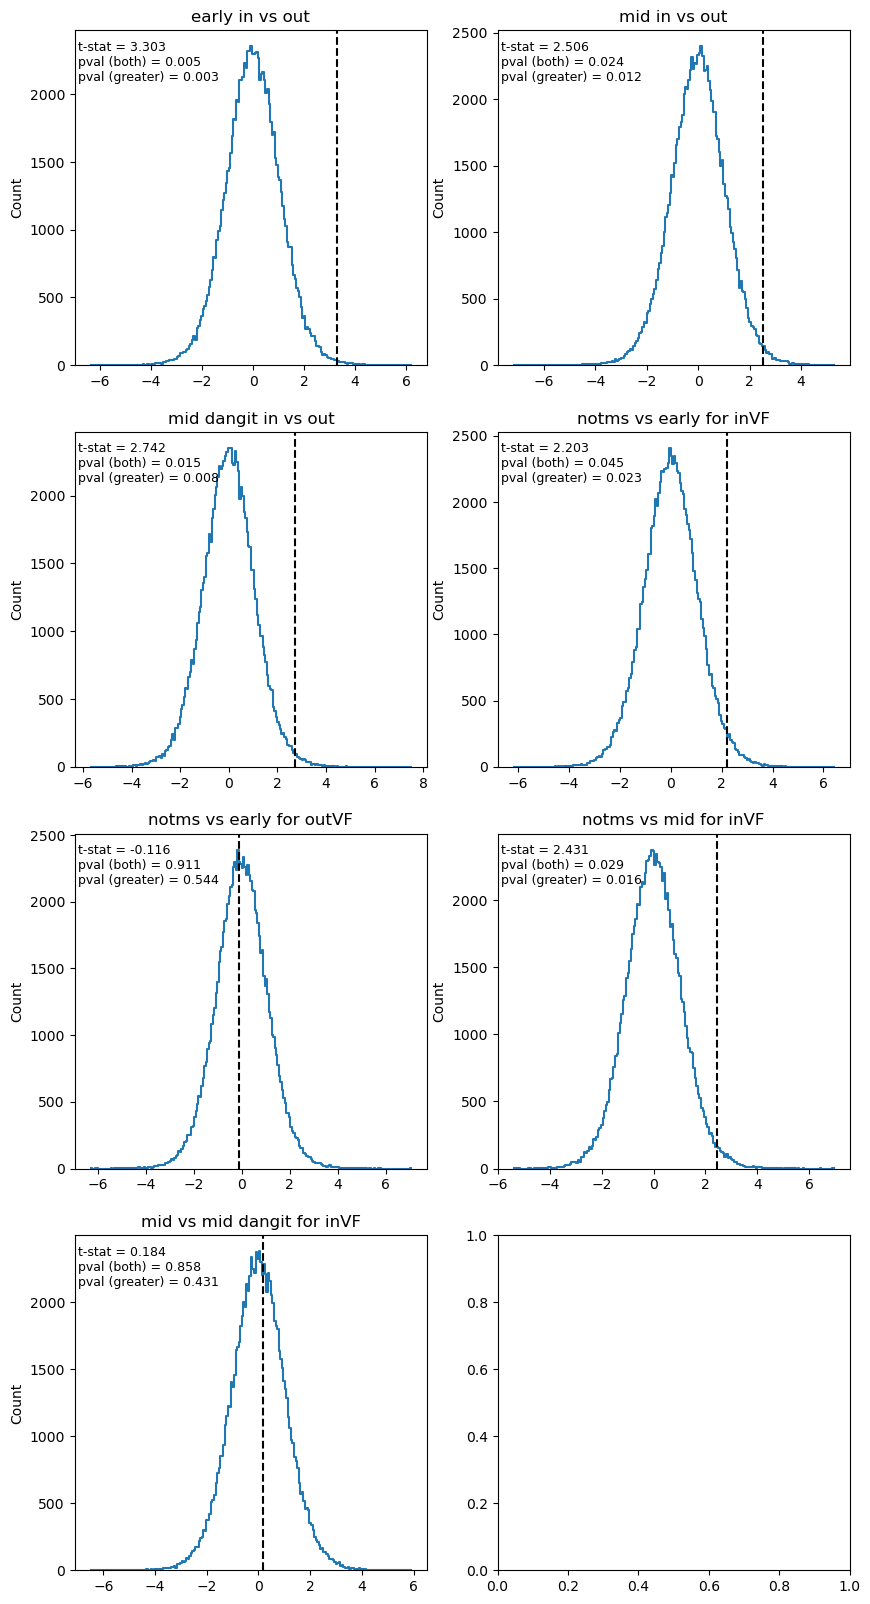

In [5]:
def plot_permutation_result(tstat_compiled, tstat_real, pval_2side, pval_1side, ii, pairs_to_test, ax):
    title_text = pairs_to_test[i][4]
    sns.histplot(tstat_compiled[:, ii], element='step', fill=False, ax=ax)
    ax.axvline(x=tstat_real[ii], color='k', linestyle='--')
    #ax.set_xlim([-6, 6])
    x1, x2 = ax.get_xlim()
    y1, y2 = ax.get_ylim()
    ax.text(x1 + (x2-x1) * 0.01, y2 - (y2-y1) * 0.15, 
            f't-stat = {tstat_real[ii]:.3f}\npval (both) = {pval_2side[ii]:.3f}\npval (greater) = {pval_1side[ii]:.3f}', 
            fontsize=9, color='black')
    ax.set_title(title_text)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]
for i in range(len(pairs_to_test)):
    plot_permutation_result(tstat_compiled, tstat_real, pval_2side, pval_1side, i, pairs_to_test, axes[i])
plt.show()

### Check for Learning Curve

In [ ]:
fig, axs = plt.subplots(len(sub_list_filt), 5, figsize=(20, 7 * len(sub_list)))

for sub in range(len(sub_list_filt)):
    this_sub = sub_list_filt[sub]
    for day in range(5):
        df_today_pro = df_nocalib_filt[(df_nocalib_filt['subjID'] == this_sub) & (df_nocalib_filt['day'] == day+1) & (df_nocalib_filt['ispro'] == 1)]
        df_today_anti = df_nocalib_filt[(df_nocalib_filt['subjID'] == this_sub) & (df_nocalib_filt['day'] == day+1) & (df_nocalib_filt['ispro'] == 0)]
        this_tr_num_pro = ((df_today_pro['rnum'] - 1) * 40 + df_today_pro['tnum'])
        this_tr_num_anti = ((df_today_anti['rnum'] - 1) * 40 + df_today_anti['tnum'])

        axs[sub, day].plot(this_tr_num_pro, df_today_pro['ierr'], 'ko', markersize=2) 
        axs[sub, day].plot(this_tr_num_anti, df_today_anti['ierr'], 'ro', markersize=2) 

        if day >= 3:  
            df_today = df_nocalib_all5_filt[(df_nocalib_all5_filt['subjID'] == this_sub) & (df_nocalib_all5_filt['day'] == day+1)]
            this_tr_num = ((df_today['rnum'] - 1) * 40 + df_today['tnum'])

            if day == 3:  
                color = 'go' 
            elif day == 4:  
                color = 'bo' 

            axs[sub, day].plot(this_tr_num, df_today['ierr'], color, markersize=2)
        axs[sub, day].set_xlabel('Trial')
        axs[sub, day].set_ylabel('MGS Error (dva)')
        axs[sub, day].set_ylim([0, 6.5])
        axs[sub, day].set_title(f'Sub = {this_sub}, Day = {day + 1}')

plt.show()

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

mov_window = 7 

fig, axs = plt.subplots(len(sub_list_filt), 5, figsize=(20, 7 * len(sub_list_filt)))

for sub in range(len(sub_list_filt)):
    this_sub = sub_list_filt[sub]
    for day in range(5):
        is_istms_zero_day = False
        if day < 3:
            df_today_pro = df_calib_filt[(df_calib_filt['subjID'] == this_sub) & (df_calib_filt['day'] == day+1) & (df_calib_filt['ispro'] == 1)]
            df_today_anti = df_calib_filt[(df_calib_filt['subjID'] == this_sub) & (df_calib_filt['day'] == day+1) & (df_calib_filt['ispro'] == 0)]
            this_tr_num_pro = ((df_today_pro['rnum'] - 1) * 40 + df_today_pro['tnum'])
            this_tr_num_anti = ((df_today_anti['rnum'] - 1) * 40 + df_today_anti['tnum'])

            ma_error_pro = moving_average(df_today_pro['ierr'], mov_window)
            ma_error_anti = moving_average(df_today_anti['ierr'], mov_window)

            adj_tr_num_pro = this_tr_num_pro[:len(ma_error_pro)]
            adj_tr_num_anti = this_tr_num_anti[:len(ma_error_anti)]

            axs[sub, day].plot(adj_tr_num_pro, ma_error_pro, 'k-', label='Pro')  
            axs[sub, day].plot(adj_tr_num_anti, ma_error_anti, 'r-', label='Anti')  

            if df_today_pro['istms'].eq(0).any() or df_today_anti['istms'].eq(0).any():
                is_istms_zero_day = True

            for block_start in np.unique(df_today_pro['rnum']):
                axs[sub, day].axvline(x=((block_start - 1) * 40), color='grey', linestyle='--', alpha=0.5)
            for block_start in np.unique(df_today_anti['rnum']):
                axs[sub, day].axvline(x=((block_start - 1) * 40), color='grey', linestyle='--', alpha=0.5)

        elif day >= 3:
            if this_sub in sub_list_all5:
                df_today = df_calib_filt[(df_calib_filt['subjID'] == this_sub) & (df_calib_filt['day'] == day+1)]
                this_tr_num = ((df_today['rnum'] - 1) * 40 + df_today['tnum'])
                ma_error = moving_average(df_today['ierr'], mov_window)
                adj_tr_num = this_tr_num[:len(ma_error)]

                if day == 3:
                    color = 'g-'
                elif day == 4:
                    color = 'b-'
                
                axs[sub, day].plot(adj_tr_num, ma_error, color, label='TMS')

                for block_start in np.unique(df_today['rnum']):
                    axs[sub, day].axvline(x=((block_start - 1) * 40), color='grey', linestyle='--', alpha=0.5)

        if is_istms_zero_day:
            axs[sub, day].spines['top'].set_color('orange')
            axs[sub, day].spines['right'].set_color('orange')
            axs[sub, day].spines['left'].set_color('orange')
            axs[sub, day].spines['bottom'].set_color('orange')
            axs[sub, day].spines['top'].set_linewidth(2)
            axs[sub, day].spines['right'].set_linewidth(2)
            axs[sub, day].spines['left'].set_linewidth(2)
            axs[sub, day].spines['bottom'].set_linewidth(2)

        axs[sub, day].set_xlabel('Trial')
        axs[sub, day].set_ylabel('MGS Error (dva)')
        axs[sub, day].set_ylim([0, 6.5])
        axs[sub, day].set_title(f'Sub = {this_sub}, Day = {day + 1}')
        axs[sub, day].legend()

plt.show()

### Pairwise plots for conditions

In [ ]:
from statsmodels.stats.power import TTestPower 
from statsmodels.stats.power import TTestIndPower 
df_plot = err_sum_all5_analysis
mean_x = df_plot[(df_plot['time']=='mid') & (df_plot['VF']==1)]['mean'] 
mean_y = df_plot[(df_plot['time']=='notms') & (df_plot['VF']==1)]['mean'] 
cohens_d = (np.mean(mean_x)- np.mean(mean_y)) / np.sqrt((np.std(mean_x) ** 2 + np.std(mean_y, ) ** 2) / 2.0)

# cohens_d = (tdf['mean'] - np.mean(tdf['mean']))/np.std(tdf['mean'])
print(cohens_d)

alpha = 0.05
power = 0.8
  
# perform power analysis to find sample size  
# for given effect 
obj = TTestPower() 
n = obj.solve_power(effect_size=cohens_d, alpha=alpha, power=power,  
                     alternative='larger') 
print(n)

obj = TTestIndPower() 
n = obj.solve_power(effect_size=cohens_d, alpha=alpha, power=power,  
                     ratio=1, alternative='two-sided') 
print(n)

In [ ]:
df_plot = err_sum_all5_analysis
plt.figure(figsize=(20, 10))
times = ['notms', 'mid', 'early', 'mid dangit']

time_pairs = [
    ('notms', 'early'),
    ('notms', 'mid'),
    ('notms', 'mid dangit'),
    ('early', 'mid'),
    ('mid', 'mid dangit'),
 ]

# Create figure for the subplots
plt.figure(figsize=(8, 10))

# Plotting each pair of times
for i, (time1, time2) in enumerate(time_pairs, 1):
    plt.subplot(3, 2, i)

    # Merging the mean values for the two times for each subject and condition
    df_time1 = df_plot[df_plot['time'] == time1][['subjID', 'mean', 'VF', 'Condition']]
    df_time2 = df_plot[df_plot['time'] == time2][['subjID', 'mean', 'VF', 'Condition']]
    df_time1.rename(columns={'mean': f'mean_{time1}'}, inplace=True)
    df_time2.rename(columns={'mean': f'mean_{time2}'}, inplace=True)
    merged_df = pd.merge(df_time1, df_time2, on=['subjID', 'VF'])#, 'VF', 'Condition'])

    sns.scatterplot(data=merged_df, x=f'mean_{time1}', y=f'mean_{time2}', hue='VF', palette='deep')
    plt.plot([0, 3], [0, 3], 'k--')
    for vf in [0, 1]:
        vf_data = merged_df[merged_df['VF'] == vf]
        corr, _ = stats.pearsonr(vf_data[f'mean_{time1}'], vf_data[f'mean_{time2}'])
        plt.text(0.1, 2.8 - 0.2 * vf, f'VF={vf}: r={corr:.2f}', fontsize=9, color='blue' if vf == 0 else 'red')

    plt.title(f'{time1} vs {time2}')
    plt.xlim([0, 3])
    plt.ylim([0, 3])
    plt.xlabel(f'{time1}')
    plt.ylabel(f'{time2}')
    plt.legend(title='VF', loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))

for i, time in enumerate(times, 1):
    plt.subplot(2, 2, i)

    df_inVF = df_plot[(df_plot['time'] == time) & (df_plot['VF'] == 1)][['subjID', 'mean']]
    df_outVF = df_plot[(df_plot['time'] == time) & (df_plot['VF'] == 0)][['subjID', 'mean']]
    df_inVF.rename(columns={'mean': 'mean_inVF'}, inplace=True)
    df_outVF.rename(columns={'mean': 'mean_outVF'}, inplace=True)
    merged_df = pd.merge(df_inVF, df_outVF, on='subjID')

    sns.scatterplot(data=merged_df, x='mean_inVF', y='mean_outVF')
    plt.plot([0, 3], [0, 3], 'k--')
    plt.xlim([0, 3])
    plt.ylim([0, 3])
    corr, _ = stats.pearsonr(merged_df['mean_inVF'], merged_df['mean_outVF'])
    plt.text(0.1, 2.8, f'r={corr:.2f}', fontsize=9, color='black')
    plt.title(f'Time: {time}')
    plt.xlabel('Error inVF')
    plt.ylabel('Error outVF')

plt.tight_layout()
plt.show()

## Did subjects use semantic knowledge of target location?

In [ ]:
sub_list = np.unique(df['subjID'].values)
#sub_list = [1, 3]
fig, axs = plt.subplots(len(sub_list), 3, figsize = (20, 5*len(sub_list)))
x = [0.5, 0.7, 0.9, 1.3, 1.5, 1.7, 2.1, 2.3, 2.5, 2.9, 3.1, 3.3]
bar_width = 0.2
labels = ['actual\nerror', 'semantic\nerror', 'max\nerror', 'actual\nerror', 'semantic\nerror', 'max\nerror',
          'actual\nerror', 'semantic\nerror', 'max\nerror', 'actual\nerror', 'semantic\nerror', 'max\nerror']

legend_handles = []
for sub in range(len(sub_list)):
    this_sub = sub_list[sub]
    for day in range(3):
        df_pro_instimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 1) & (df['instimVF'] == 1)]
        df_pro_outstimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 1) & (df['instimVF'] == 0)]
        df_anti_instimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 0) & (df['instimVF'] == 1)]
        df_anti_outstimVF = df[(df['subjID'] == this_sub) & (df['day'] == day+1) & (df['ispro'] == 0) & (df['instimVF'] == 0)]
        
        tr_num_pro_instimVF = ((df_pro_instimVF['rnum'] - 1) * 40 + df_pro_instimVF['tnum'])
        tr_num_pro_outstimVF = ((df_pro_outstimVF['rnum'] - 1) * 40 + df_pro_outstimVF['tnum'])
        tr_num_anti_instimVF = ((df_anti_instimVF['rnum'] - 1) * 40 + df_anti_instimVF['tnum'])
        tr_num_anti_outstimVF = ((df_anti_outstimVF['rnum'] - 1) * 40 + df_anti_outstimVF['tnum'])
        
        Xpi_sem = np.median(df_pro_instimVF['TarX'])
        Ypi_sem = np.median(df_pro_instimVF['TarY'])
        Xpo_sem = np.median(df_pro_outstimVF['TarX'])
        Ypo_sem = np.median(df_pro_outstimVF['TarY'])
        Xai_sem = np.median(df_anti_instimVF['TarX'])
        Yai_sem = np.median(df_anti_instimVF['TarY'])
        Xao_sem = np.median(df_anti_outstimVF['TarX'])
        Yao_sem = np.median(df_anti_outstimVF['TarY'])

        errpi_sem = np.sqrt((df_pro_instimVF['isaccX']-Xpi_sem)**2+(df_pro_instimVF['isaccY']-Ypi_sem)**2)
        errpo_sem = np.sqrt((df_pro_outstimVF['isaccX']-Xpo_sem)**2+(df_pro_outstimVF['isaccY']-Ypo_sem)**2)
        errai_sem = np.sqrt((df_anti_instimVF['isaccX']-Xai_sem)**2+(df_anti_instimVF['isaccY']-Yai_sem)**2)
        errao_sem = np.sqrt((df_anti_outstimVF['isaccX']-Xao_sem)**2+(df_anti_outstimVF['isaccY']-Yao_sem)**2)
        
        tarpi_sem = np.sqrt((df_pro_instimVF['TarX']-Xpi_sem)**2+(df_pro_instimVF['TarY']-Ypi_sem)**2)
        tarpo_sem = np.sqrt((df_pro_outstimVF['TarX']-Xpo_sem)**2+(df_pro_outstimVF['TarY']-Ypo_sem)**2)
        tarai_sem = np.sqrt((df_anti_instimVF['TarX']-Xai_sem)**2+(df_anti_instimVF['TarY']-Yai_sem)**2)
        tarao_sem = np.sqrt((df_anti_outstimVF['TarX']-Xao_sem)**2+(df_anti_outstimVF['TarY']-Yao_sem)**2)
        

        errpi = df_pro_instimVF['ierr']
        errpo = df_pro_outstimVF['ierr']
        errai = df_anti_instimVF['ierr']
        errao = df_anti_outstimVF['ierr']
        
        
        pi_mean = [np.mean(errpi), np.mean(errpi_sem), np.mean(tarpi_sem)]
        po_mean = [np.mean(errpo), np.mean(errpo_sem), np.mean(tarpo_sem)]
        ai_mean = [np.mean(errai), np.mean(errai_sem), np.mean(tarai_sem)]
        ao_mean = [np.mean(errao), np.mean(errao_sem), np.mean(tarao_sem)]
        pi_var = [sem(errpi), sem(errpi_sem), sem(tarpi_sem)]
        po_var = [sem(errpo), sem(errpo_sem), sem(tarpo_sem)]
        ai_var = [sem(errai), sem(errai_sem), sem(tarai_sem)]
        ao_var = [sem(errao), sem(errao_sem), sem(tarao_sem)]
        
        bar1 = axs[sub, day].bar(x[:3], pi_mean, bar_width, label='pro instimVF', yerr=pi_var, capsize=5)
        bar2 = axs[sub, day].bar(x[3:6], po_mean, bar_width, label='pro outstimVF', yerr=po_var, capsize=5)
        bar3 = axs[sub, day].bar(x[6:9], ai_mean, bar_width, label='anti instimVF', yerr=ai_var, capsize=5)
        bar4 = axs[sub, day].bar(x[9:], ao_mean, bar_width, label='anti outstimVF', yerr=ao_var, capsize=5)
        legend_handles.extend([bar1, bar2, bar3, bar4])
        axs[sub, day].set_ylabel('isacc_err')
        axs[sub, day].set_title('Sub = ' + str(this_sub) + ', Day = ' + str(day))
        axs[sub, day].set_xticks(x)
        axs[sub, day].set_xticklabels(labels, rotation = 45)
        #axs[sub, day].legend()
fig.legend(legend_handles, ['pro instimVF', 'pro outstimVF', 'anti instimVF', 'anti outstimVF'],
           loc='upper right', bbox_to_anchor=(1.0, 1.0))
# for ax in axs[-1]:
#     ax.set_xticklabels(labels, rotation=45, ha='right')  # Adjust rotation angle as needed

plt.subplots_adjust(right=0.85)  

#fig.suptitle('Learning curve')
plt.tight_layout(rect=[0, 0, 0.9, 1.0])  # Adjust the rect parameter as needed
plt.savefig(save_folder + 'semantic_strategy.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
sub_list = np.unique(df['subjID'].values)
#sub_list = [1, 3]
fig, axs = plt.subplots(len(sub_list), 1, figsize = (20, 5*len(sub_list)))
x = [0.5, 0.7, 0.9, 1.3, 1.5, 1.7, 2.1, 2.3, 2.5, 2.9, 3.1, 3.3]
bar_width = 0.2
labels = ['actual\nerror', 'semantic\nerror', 'centroid\nerror', 'actual\nerror', 'semantic\nerror', 'centroid\nerror',
          'actual\nerror', 'semantic\nerror', 'centroid\nerror', 'actual\nerror', 'semantic\nerror', 'centroid\nerror']

legend_handles = []
for sub in range(len(sub_list)):
    this_sub = sub_list[sub]
    #for day in range(3):
    df_pro_instimVF = df[(df['subjID'] == this_sub) & (df['ispro'] == 1) & (df['instimVF'] == 1)]
    df_pro_outstimVF = df[(df['subjID'] == this_sub)  & (df['ispro'] == 1) & (df['instimVF'] == 0)]
    df_anti_instimVF = df[(df['subjID'] == this_sub) & (df['ispro'] == 0) & (df['instimVF'] == 1)]
    df_anti_outstimVF = df[(df['subjID'] == this_sub) & (df['ispro'] == 0) & (df['instimVF'] == 0)]
    
    tr_num_pro_instimVF = ((df_pro_instimVF['rnum'] - 1) * 40 + df_pro_instimVF['tnum'])
    tr_num_pro_outstimVF = ((df_pro_outstimVF['rnum'] - 1) * 40 + df_pro_outstimVF['tnum'])
    tr_num_anti_instimVF = ((df_anti_instimVF['rnum'] - 1) * 40 + df_anti_instimVF['tnum'])
    tr_num_anti_outstimVF = ((df_anti_outstimVF['rnum'] - 1) * 40 + df_anti_outstimVF['tnum'])
    
    Xpi_sem = np.median(df_pro_instimVF['TarX'])
    Ypi_sem = np.median(df_pro_instimVF['TarY'])
    Xpo_sem = np.median(df_pro_outstimVF['TarX'])
    Ypo_sem = np.median(df_pro_outstimVF['TarY'])
    Xai_sem = np.median(df_anti_instimVF['TarX'])
    Yai_sem = np.median(df_anti_instimVF['TarY'])
    Xao_sem = np.median(df_anti_outstimVF['TarX'])
    Yao_sem = np.median(df_anti_outstimVF['TarY'])

    errpi_sem = np.sqrt((df_pro_instimVF['isaccX']-Xpi_sem)**2+(df_pro_instimVF['isaccY']-Ypi_sem)**2)
    errpo_sem = np.sqrt((df_pro_outstimVF['isaccX']-Xpo_sem)**2+(df_pro_outstimVF['isaccY']-Ypo_sem)**2)
    errai_sem = np.sqrt((df_anti_instimVF['isaccX']-Xai_sem)**2+(df_anti_instimVF['isaccY']-Yai_sem)**2)
    errao_sem = np.sqrt((df_anti_outstimVF['isaccX']-Xao_sem)**2+(df_anti_outstimVF['isaccY']-Yao_sem)**2)
    
    tarpi_sem = np.sqrt((df_pro_instimVF['TarX']-Xpi_sem)**2+(df_pro_instimVF['TarY']-Ypi_sem)**2)
    tarpo_sem = np.sqrt((df_pro_outstimVF['TarX']-Xpo_sem)**2+(df_pro_outstimVF['TarY']-Ypo_sem)**2)
    tarai_sem = np.sqrt((df_anti_instimVF['TarX']-Xai_sem)**2+(df_anti_instimVF['TarY']-Yai_sem)**2)
    tarao_sem = np.sqrt((df_anti_outstimVF['TarX']-Xao_sem)**2+(df_anti_outstimVF['TarY']-Yao_sem)**2)
    

    errpi = df_pro_instimVF['ierr']
    errpo = df_pro_outstimVF['ierr']
    errai = df_anti_instimVF['ierr']
    errao = df_anti_outstimVF['ierr']
    
    
    pi_mean = [np.mean(errpi), np.mean(errpi_sem), np.mean(tarpi_sem)]
    po_mean = [np.mean(errpo), np.mean(errpo_sem), np.mean(tarpo_sem)]
    ai_mean = [np.mean(errai), np.mean(errai_sem), np.mean(tarai_sem)]
    ao_mean = [np.mean(errao), np.mean(errao_sem), np.mean(tarao_sem)]
    pi_var = [sem(errpi), sem(errpi_sem), sem(tarpi_sem)]
    po_var = [sem(errpo), sem(errpo_sem), sem(tarpo_sem)]
    ai_var = [sem(errai), sem(errai_sem), sem(tarai_sem)]
    ao_var = [sem(errao), sem(errao_sem), sem(tarao_sem)]
    
    bar1 = axs[sub].bar(x[:3], pi_mean, bar_width, label='pro instimVF', yerr=pi_var, capsize=5)
    bar2 = axs[sub].bar(x[3:6], po_mean, bar_width, label='pro outstimVF', yerr=po_var, capsize=5)
    bar3 = axs[sub].bar(x[6:9], ai_mean, bar_width, label='anti instimVF', yerr=ai_var, capsize=5)
    bar4 = axs[sub].bar(x[9:], ao_mean, bar_width, label='anti outstimVF', yerr=ao_var, capsize=5)
    legend_handles.extend([bar1, bar2, bar3, bar4])
    axs[sub].set_ylabel('isacc_err')
    axs[sub].set_title('Sub = ' + str(this_sub))
    axs[sub].set_xticks(x)
    axs[sub].set_xticklabels(labels)
        #axs[sub, day].legend()
fig.legend(legend_handles, ['pro instimVF', 'pro outstimVF', 'anti instimVF', 'anti outstimVF'],
           loc='upper right', bbox_to_anchor=(1.0, 1.0))
# for ax in axs[-1]:
#     ax.set_xticklabels(labels, rotation=45, ha='right')  # Adjust rotation angle as needed

plt.subplots_adjust(right=0.85)  

#fig.suptitle('Learning curve')
plt.tight_layout(rect=[0, 0, 0.9, 1.0])  # Adjust the rect parameter as needed
plt.savefig(save_folder + 'semantic_strategy_subjectwise.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
X1 = [0.3, 0.8, 1.3]
bWidth = 0.2
X2 = [round(x + 0.1, 1) for x in X1]
X_sum = [sum(value) for value in zip(X1, X2)]
x_tick_pos = [round(x/2, 2) for x in X1]
x_label_names = ['No TMS', 'MGS inVF', 'MGS outVF']
Y1_equal = [1, 1, 1]
Y1_specific = [1, 2, 1]
Y1_global = [1, 2, 2]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor((33/255, 33/255, 33/255))
axes_fontsize = 12
title_fontsize = 16
for ii in range(3):
    ax[ii].set_facecolor((33/255, 33/255, 33/255))
    ax[ii].spines['bottom'].set_color('white')
    ax[ii].spines['top'].set_color('white')
    ax[ii].spines['left'].set_color('white')
    ax[ii].spines['right'].set_color('white')
    ax[ii].xaxis.label.set_color('white')
    ax[ii].yaxis.label.set_color('white')
    ax[ii].tick_params(axis='x', colors='white')
    ax[ii].tick_params(axis='y', colors=(33/255, 33/255, 33/255))
    ax[ii].set_ylim((0, 2.2))
    ax[ii].set_xticks(X1, x_label_names, fontsize=axes_fontsize)
    ax[ii].set_ylabel('MGS error', fontsize=axes_fontsize, labelpad=-20)
    if ii == 0:
        bars = ax[ii].bar(X1, Y1_equal, width = bWidth)
        ax[ii].set_title('No effect', color = 'white', fontsize=title_fontsize)
    elif ii == 1:
        bars = ax[ii].bar(X1, Y1_specific, width = bWidth)
        ax[ii].set_title('Specific', color = 'white', fontsize=title_fontsize)
    elif ii == 2:
        bars = ax[ii].bar(X1, Y1_global, width = bWidth)
        ax[ii].set_title('Global', color = 'white', fontsize=title_fontsize)
    
    bars[0].set_color("#1B9E77")
    bars[1].set_color("#D95F02")
    bars[2].set_color("#7570B3")
plt.show()

In [ ]:
d_good = df[df['subjID'] != 18]
pro_rt = d_good[(d_good['ispro']==1) & (d_good['istms']== 0) & (d_good['instimVF'] == 1)]['isacc_rt']
anti_rt = d_good[(d_good['ispro']==0) & (d_good['istms']== 1) & (d_good['instimVF'] == 1)]['isacc_rt']

max_rt = max(np.max(pro_rt), np.max(anti_rt))
#print(max_rt)
nbins = 50
t_bins = np.linspace(0, max_rt, nbins)
t_res = 1/nbins
p_count = np.zeros((nbins, 1))
a_count = np.zeros((nbins, 1))
for ii in range(nbins):
    p_count[ii] = len(np.where((t_bins[ii]<pro_rt) & (pro_rt<t_bins[ii]+t_res))[0])
    a_count[ii] = len(np.where((t_bins[ii]<anti_rt) & (anti_rt<t_bins[ii]+t_res))[0])
p_count = np.cumsum(p_count)/len(pro_rt) * 100
a_count = np.cumsum(a_count)/len(anti_rt) * 100
print('Pro-saccade equivalence point: ' + str(int(round(t_bins[np.where(p_count < 75)[0][-1]]*1000, 0))) + 's')
print('Anti-saccade equivalence point: ' + str(int(round(t_bins[np.where(a_count < 75)[0][-1]]*1000, 0))) + 's')

plt.figure()
plt.plot(t_bins*1000, p_count, 'b-')
plt.plot(t_bins*1000, a_count, 'r-')
plt.xlabel('RT (ms)')
plt.ylabel('% Cummulative')
plt.title('No TMS')
plt.show()

In [ ]:
## Check for any existing trend in data due to eccentricity or angular width
subjIDs = df['subjID'].unique()
angular_width = np.zeros((len(subjIDs), 2) )
eccs = np.zeros((len(subjIDs),2) )
mean_err = np.zeros((len(subjIDs), 2))
median_err = np.zeros((len(subjIDs), 2))
var_err = np.zeros((len(subjIDs), 2))
range_err = np.zeros((len(subjIDs), 2))
err_met = 'isacc_err'

for ii in range(len(subjIDs)):
    this_subj_df_pro = df[(df['subjID']==subjIDs[ii]) & (df['TMS_condition']=='No TMS') & (df['ispro']==1) ]
    this_subj_df_anti = df[(df['subjID']==subjIDs[ii]) & (df['TMS_condition']=='No TMS') & (df['ispro']==0)]
    mean_err[ii, 0] = np.nanmean(this_subj_df_pro[err_met])
    median_err[ii, 0] = np.nanmedian(this_subj_df_pro[err_met])
    var_err[ii, 0] = np.nanvar(this_subj_df_pro[err_met])
    range_err[ii, 0] = np.nanmax(this_subj_df_pro[err_met]) - np.nanmin(this_subj_df_pro[err_met])
    mean_err[ii, 1] = np.nanmean(this_subj_df_anti[err_met])
    median_err[ii, 1] = np.nanmedian(this_subj_df_anti[err_met])
    var_err[ii, 1] = np.nanvar(this_subj_df_anti[err_met])
    range_err[ii, 1] = np.nanmax(this_subj_df_anti[err_met]) - np.nanmin(this_subj_df_anti[err_met])
    angular_width[ii, 0] = (this_subj_df_pro['TarTheta_rotated'].max() - this_subj_df_pro['TarTheta_rotated'].min()) * (180/np.pi)
    angular_width[ii, 1] = (this_subj_df_anti['TarTheta_rotated'].max() - this_subj_df_anti['TarTheta_rotated'].min()) * (180/np.pi)
    eccs[ii, 0] = this_subj_df_pro['TarRadius'].mean()
    eccs[ii, 1] = this_subj_df_anti['TarRadius'].mean()

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))
axs[0, 0].plot(eccs[:, 0], mean_err[:, 0], 'bo')
axs[0, 0].plot(eccs[:, 1], mean_err[:, 1], 'ro')
axs[0, 0].set_xlabel('eccentricity')
axs[0, 0].set_ylabel('mean err')

axs[0, 1].plot(eccs[:, 0], median_err[:, 0], 'bo')
axs[0, 1].plot(eccs[:, 1], median_err[:, 1], 'ro')
axs[0, 1].set_xlabel('eccentricity')
axs[0, 1].set_ylabel('median err')

axs[0, 2].plot(eccs[:, 0], var_err[:, 0], 'bo')
axs[0, 2].plot(eccs[:, 1], var_err[:, 1], 'ro')
axs[0, 2].set_xlabel('eccentricity')
axs[0, 2].set_ylabel('var err')

axs[0, 3].plot(eccs[:, 0], range_err[:, 0], 'bo')
axs[0, 3].plot(eccs[:, 1], range_err[:, 1], 'ro')
axs[0, 3].set_xlabel('eccentricity')
axs[0, 3].set_ylabel('range err')

axs[1, 0].plot(angular_width[:, 0], mean_err[:, 0], 'bo')
axs[1, 0].plot(angular_width[:, 1], mean_err[:, 1], 'ro')
axs[1, 0].set_xlabel('angular_width')
axs[1, 0].set_ylabel('mean err')

axs[1, 1].plot(angular_width[:, 0], median_err[:, 0], 'bo')
axs[1, 1].plot(angular_width[:, 1], median_err[:, 1], 'ro')
axs[1, 1].set_xlabel('angular_width')
axs[1, 1].set_ylabel('median err')

axs[1, 2].plot(angular_width[:, 0], var_err[:, 0], 'bo')
axs[1, 2].plot(angular_width[:, 1], var_err[:, 1], 'ro')
axs[1, 2].set_xlabel('angular_width')
axs[1, 2].set_ylabel('var err')

axs[1, 3].plot(angular_width[:, 0], range_err[:, 0], 'bo')
axs[1, 3].plot(angular_width[:, 1], range_err[:, 1], 'ro')
axs[1, 3].set_xlabel('angular_width')
axs[1, 3].set_ylabel('range err')
plt.show()
